# Part 1: Getting started

### NB: If you want to complete synthesis you MUST do the following:

1. Submit an interactive job using `condor_submit -interactive tutorial.job`
2. In the job run:
     ```
     cd /home/hep/lr1424/
    conda activate hls4ml-tutorial_OPENML
    source /opt/local/Vitis_HLS/2024.1/settings64.sh
    jupyter notebook --no-browser --ip=0.0.0.0 --port=60001 --NotebookApp.token='' --NotebookApp.password=''
    ```

3. Open up a new terminal in lx04 and run `ssh -L 127.0.0.1:60001:lxfw00.hep.ph.ic.ac.uk:60001 lr1424@lxfw00.hep.ph.ic.ac.uk`
4. Go to the top right of VS Code Jupyter Notebook kernel selection, select another kernel, existing Jupyter Server, and then paste in http://127.0.0.1:60001/

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

# os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH'] # Use this later for Synthesis!

2025-02-25 16:29:07.439757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML - Skip This Part if you have already downloaded the dataset

In [2]:
# data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=False)
# X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
# print(data['feature_names'])
# print(X.shape, y.shape)
# print(X[:5])
# print(y[:5])

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
# y = le.fit_transform(y)
# y = to_categorical(y, 5)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(y[:5])

In [5]:
# scaler = StandardScaler()
# X_train_val = scaler.fit_transform(X_train_val)
# X_test = scaler.transform(X_test)

In [6]:
# np.save('X_train_val.npy', X_train_val)
# np.save('X_test.npy', X_test)
# np.save('y_train_val.npy', y_train_val)
# np.save('y_test.npy', y_test)
# label_encoder_classes_str = [str(cls) for cls in le.classes_]
# np.save('classes.npy', label_encoder_classes_str)

In [7]:
X_train_val = np.load('X_train_val.npy')
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

import sys
import os

# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial_OPENML"))
from callbacks import all_callbacks


In [9]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [10]:
train = False
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/KERAS_check_best_model.h5')

## Check performance
Check the accuracy and make a ROC curve

### NB: CONVERTED LABELS TO STRINGS FROM INTS 

5188/5188 [==============================] - 3s 650us/step
Accuracy: 0.7340240963855422


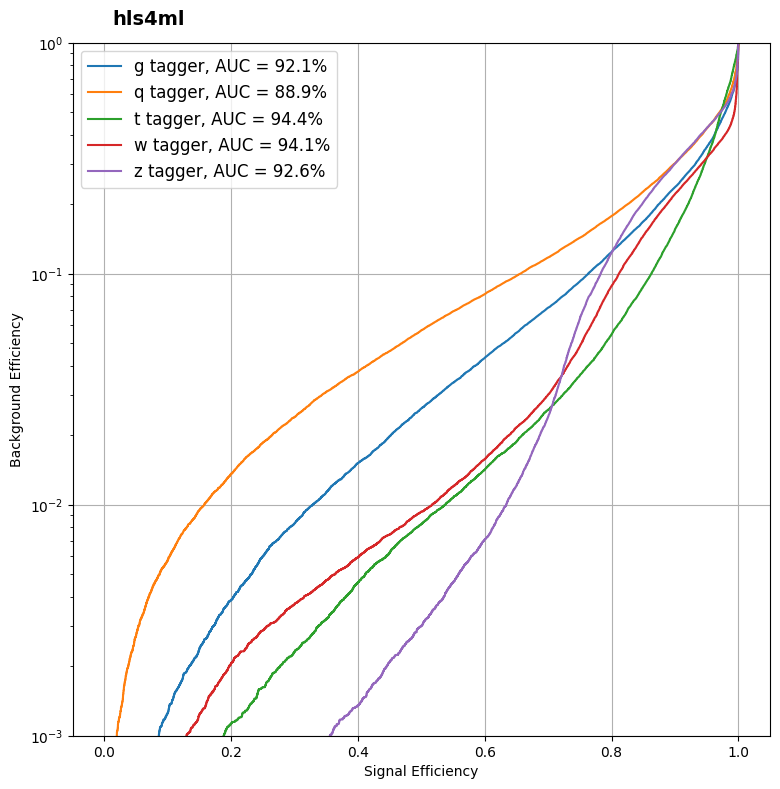

In [11]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

# Convert label_encoder.classes_ to strings
# Plot ROC curve
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [12]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj', part='xcu50-fsvh2104-2-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  S

/home/hep/lr1424/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

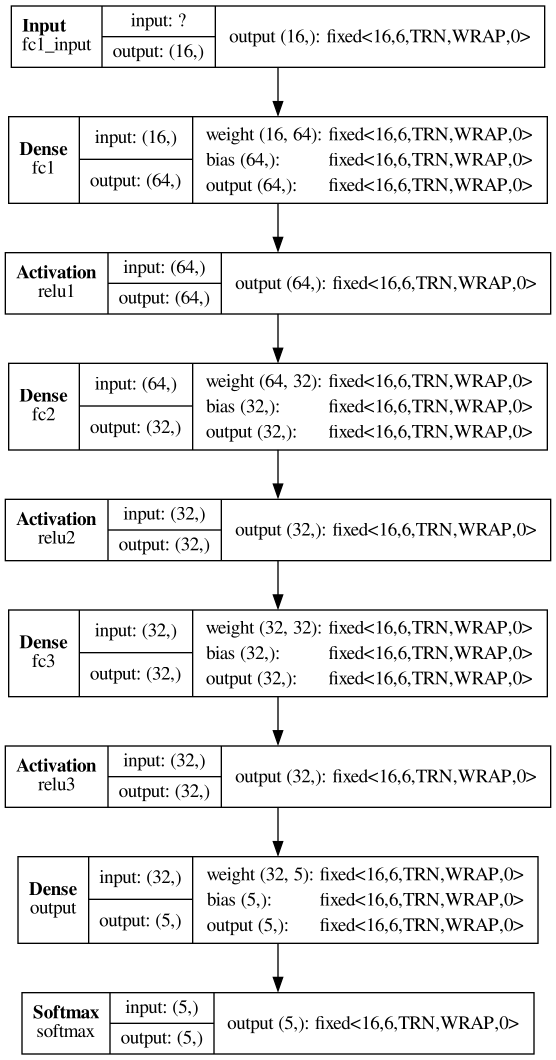

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [14]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


KeyboardInterrupt: 

## Compare
That was easy! Now let's see how the performance compares to Keras:

In [ ]:
fontsize = 15
weight = 0.1
plt.rcParams['font.size'] = fontsize
plt.rcParams["axes.titlesize"]  = fontsize + 5
# plt.rcParams["axes.titleweight"] = weight
plt.rcParams["axes.labelsize"] = fontsize
# plt.rcParams["axes.labelweight"] = weight
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize

Keras  Accuracy: 0.7340240963855422
hls4ml Accuracy: 0.7337409638554216


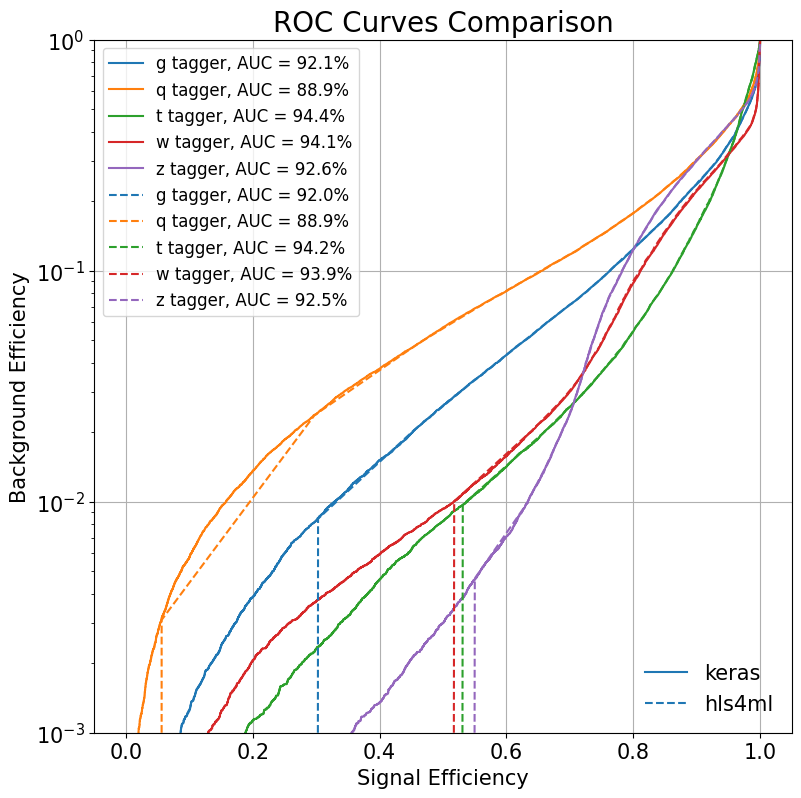

In [ ]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes, text=False)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--', text=False)
plt.title('ROC Curves Comparison')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vitis_hls.log`

In [ ]:
import subprocess

# Run the source command
subprocess.run("source /opt/local/Vitis_HLS/2024.1/settings64.sh", shell=True, executable="/bin/bash")


/bin/bash: line 1: /opt/local/Vitis_HLS/2024.1/settings64.sh: No such file or directory


CompletedProcess(args='source /opt/local/Vitis_HLS/2024.1/settings64.sh', returncode=1)

In [ ]:
import sys
import os

# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial_OPENML"))

# Simulate sourcing the script to set variables (as a fallback)
os.environ['XILINX_VITIS'] = '/opt/local/Vitis_HLS/2024.1'  # Adjust this path as needed

# Update the PATH variable
os.environ['PATH'] = os.path.join(os.environ['XILINX_VITIS'], 'bin') + ':' + os.environ.get('PATH', '')


In [ ]:
hls_model.build(csim=False)

Exception: Vitis HLS installation not found. Make sure "vitis_hls" is on PATH.

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Feb 11 17:18:33 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | m

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)